In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import parent

In [4]:
import data

In [8]:
d1_triangles, d2_triangles = data.get_dataset_triangles("train")
image_A, image_B = (x[0].cuda() for x in next(zip(d1_triangles, d2_triangles)))

In [6]:
from visualize import *

In [10]:
data_shape = [8, 1, 128, 128]
from torch import nn
from mermaidlite import *
class InverseConsistentLearningFree(nn.Module):
    def __init__(self, lmbda, noise=0):
        super(InverseConsistentLearningFree, self).__init__()
        self.sz = np.array(data_shape)
        self.spacing = 1./(self.sz[2::]-1) 
        
        self.noise = noise
        
        _id = identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
        #The displacement map from image A to image B.
        self.register_parameter(name="D_AB",
            param=torch.nn.Parameter(torch.zeros([8, 2, 128, 128])))
        #and vice versa
        self.register_parameter(name="D_BA",
            param=torch.nn.Parameter(torch.zeros([8, 2, 128, 128])))
        self.lmbda = lmbda
        
        self.random_sampling=True
    def forward(self, image_A, image_B):
        D_AB_noise = self.D_AB + self.noise * torch.randn(data_shape).cuda()
        self.phi_AB = self.D_AB + self.identityMap
        self.phi_BA = self.D_BA + self.identityMap
        
        self.warped_image_A = compute_warped_image_multiNC(
            image_A, self.phi_AB, self.spacing, 1)
        
        self.warped_image_B = compute_warped_image_multiNC(
            image_B, self.phi_BA, self.spacing, 1)
        
        

        
        Iepsilon = (
            self.identityMap 
            + torch.randn(data_shape).cuda() * 1/128
        )        
        D_BA_epsilon = compute_warped_image_multiNC(self.D_BA, Iepsilon, 
                                                    self.spacing, 1)
        
        D_AB_epsilon = compute_warped_image_multiNC(self.D_AB, Iepsilon, 
                                                    self.spacing, 1)
        
        self.approximate_identity_ABBA = compute_warped_image_multiNC( 
                self.D_AB, D_BA_epsilon + Iepsilon, self.spacing, 1
            ) + D_BA_epsilon
        
        self.approximage_identity_BAAB = compute_warped_image_multiNC(
                self.D_BA, D_AB_epsilon + Iepsilon, self.spacing, 1
        ) + D_AB_epsilon 
        
        inverse_consistency_loss = self.lmbda * (
            torch.mean(self.approximate_identity_ABBA**2) 
            + torch.mean(self.approximage_identity_BAAB**2)
        )
        similarity_loss = (
            torch.mean((self.warped_image_A - image_B)**2) + 
            torch.mean((self.warped_image_B - image_A)**2)
        )
        
        transform_magnitude= self.lmbda * torch.mean(
            (self.identityMap - self.phi_AB)**2
        )
        self.all_loss =  inverse_consistency_loss + similarity_loss
        return [x.item() for x in 
                (inverse_consistency_loss, 
                 similarity_loss, 
                 transform_magnitude)
               ]
        

In [11]:
def train_no_learning(net, optimizer, image_A, image_B, epochs=400):
    
    
    loss_history = []
    print("[", end="")
    for epoch in range(epochs):
        print("-", end="")
        if (epoch + 1) % 5 == 0:
            print("]", end="\n[")

        for step in range(300):
            optimizer.zero_grad()
            inverse_consistency_loss, similarity_loss, transform_magnitude = net(
              image_A, image_B)


            loss = net.all_loss
            loss.backward()
            optimizer.step()
            du = (net.phi_AB[:, :, 1:, :-1] 
                - net.phi_AB[:, :, :-1, :-1]).detach().cpu()
            dv = (net.phi_AB[:, :, :-1, 1:] 
                - net.phi_AB[:, :, :-1, :-1]).detach().cpu()
            dA = du[:, 0] * dv[:, 1] - du[:, 1] * dv[:, 0]

            loss_history.append([inverse_consistency_loss, 
                              similarity_loss,
                              transform_magnitude, torch.log(torch.sum(dA < 0) + 0.1)])
    print("]")
    return loss_history

In [12]:
net_nolearning = InverseConsistentLearningFree(2048)
optimizer_nolearning = torch.optim.Adam(net_nolearning.parameters(), lr=.0001)
net_nolearning.train().cuda()
train_no_learning(net_nolearning, optimizer_nolearning, image_A[:8], image_B[:8])

[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[-----]
[]


[[0.0, 1.583443522453308, 0.0, tensor(-2.3026)],
 [1.59590199473314e-05,
  1.581827163696289,
  5.843708095198963e-06,
  tensor(-2.3026)],
 [2.9155642550904304e-05,
  1.5802274942398071,
  2.02800911210943e-05,
  tensor(-2.3026)],
 [3.938464215025306e-05,
  1.5786298513412476,
  4.4542961404658854e-05,
  tensor(-2.3026)],
 [5.414576662587933e-05,
  1.5770366191864014,
  7.959598588058725e-05,
  tensor(-2.3026)],
 [7.005047518759966e-05,
  1.5754482746124268,
  0.0001251679059350863,
  tensor(-2.3026)],
 [8.578534470871091e-05,
  1.5738654136657715,
  0.00018099213775712997,
  tensor(-2.3026)],
 [0.00010020735498983413,
  1.5722885131835938,
  0.0002472831984050572,
  tensor(-2.3026)],
 [0.00011534611985553056,
  1.5707178115844727,
  0.0003242267994210124,
  tensor(-2.3026)],
 [0.00013353844406083226,
  1.5691533088684082,
  0.00041186015005223453,
  tensor(-2.3026)],
 [0.00014953773643355817,
  1.567595362663269,
  0.0005100981215946376,
  tensor(-2.3026)],
 [0.00016678031533956528,
 

In [ ]:


wdth = 9
plt.figure(dpi=800, figsize=(6, 6))
plt.rcParams.update({'axes.titlesize': 4, 'text.usetex': False})

for row in range(8):
    
    plt.subplot(8, wdth, row * wdth +1)
    if not row:
        plt.title("Image A")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.imshow(image_A[row, 0].cpu())
    plt.subplot(8, wdth, row * wdth + 2)
    if not row:
        plt.title("U-Net Grid")
    visualizeRegistrationCompact(net, image_A, image_B, row)
    
    plt.subplot(8, wdth, row * wdth + 3)
    if not row:
        plt.title("U-Net Warped")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.imshow(net.warped_image_B[row, 0].cpu().detach())
    
    plt.subplot(8, wdth, row * wdth + 4)
    if not row:
        plt.title("ΦAB ○ ΦBA")
    ax = plt.gca()
    ax.set_aspect("equal")
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    show_as_grid((compute_warped_image_multiNC(net.D_BA, net.phi_AB, net.spacing, 1) + net.phi_AB)[row])
    
    plt.subplot(8, wdth, row * wdth + 5)
    if not row:
        plt.title("Optimized Grid")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    #plt.title("Image B Warped")
    plt.imshow(net_nolearning.warped_image_B.detach().cpu()[row, 0])
    show_as_grid(net_nolearning.phi_AB[row])
    
    plt.subplot(8, wdth, row * wdth + 6)
    if not row:
        plt.title("Optimized Warped")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.imshow(net_nolearning.warped_image_B[row, 0].cpu().detach())
    
    plt.subplot(8, wdth, row * wdth + 7)
    if not row:
        plt.title("ΦAB ○ ΦBA")
    ax = plt.gca()
    ax.set_aspect("equal")
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    show_as_grid((compute_warped_image_multiNC(net_nolearning.D_BA, net_nolearning.phi_AB, net.spacing, 1) + net_nolearning.phi_AB)[row])
    
    plt.subplot(8, wdth, row * wdth + 8)
    if not row:
        plt.title("Image B")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.imshow(image_B[row, 0].cpu())
    

plt.show()

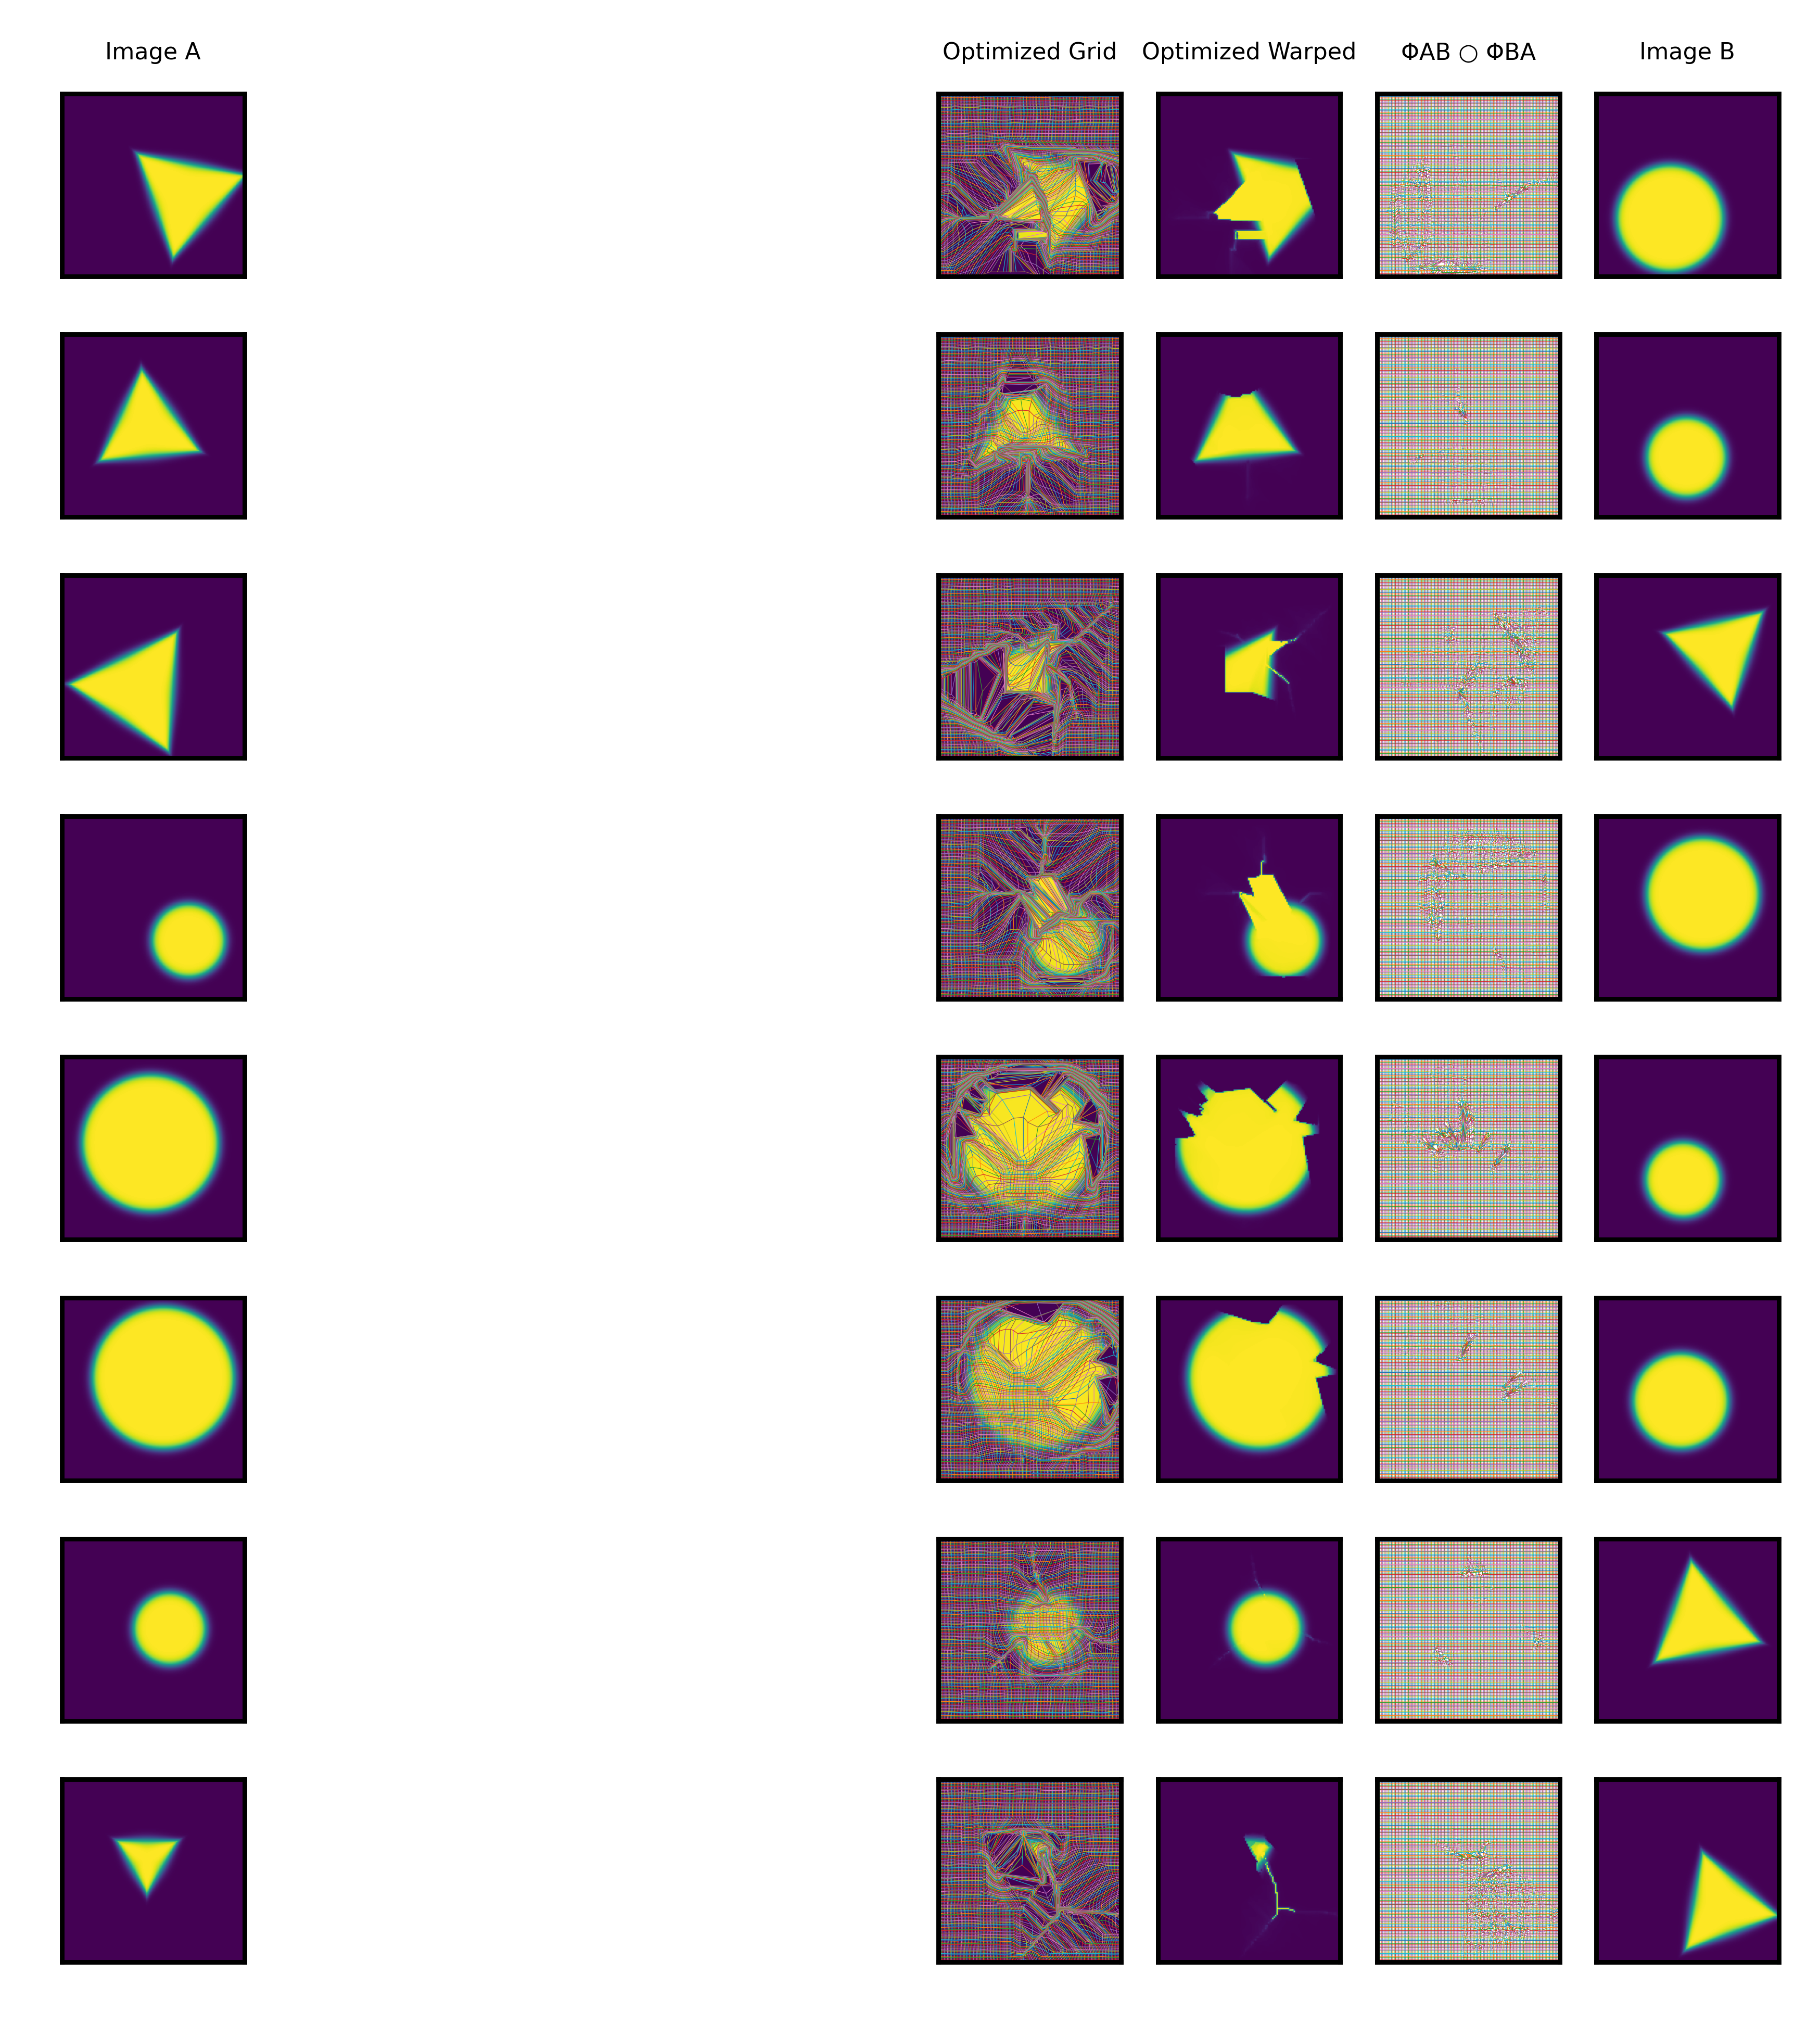

In [14]:

wdth = 9
plt.figure(dpi=800, figsize=(6, 6))
plt.rcParams.update({'axes.titlesize': 4, 'text.usetex': False})

for row in range(8):
    
    plt.subplot(8, wdth, row * wdth +1)
    if not row:
        plt.title("Image A")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.imshow(image_A[row, 0].cpu())
    
    
    plt.subplot(8, wdth, row * wdth + 5)
    if not row:
        plt.title("Optimized Grid")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    #plt.title("Image B Warped")
    plt.imshow(net_nolearning.warped_image_B.detach().cpu()[row, 0])
    show_as_grid(net_nolearning.phi_AB[row])
    
    plt.subplot(8, wdth, row * wdth + 6)
    if not row:
        plt.title("Optimized Warped")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.imshow(net_nolearning.warped_image_B[row, 0].cpu().detach())
    
    plt.subplot(8, wdth, row * wdth + 7)
    if not row:
        plt.title("ΦAB ○ ΦBA")
    ax = plt.gca()
    ax.set_aspect("equal")
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    show_as_grid((compute_warped_image_multiNC(net_nolearning.D_BA, net_nolearning.phi_AB, net_nolearning.spacing, 1) + net_nolearning.phi_AB)[row])
    
    plt.subplot(8, wdth, row * wdth + 8)
    if not row:
        plt.title("Image B")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.imshow(image_B[row, 0].cpu())
    

plt.show()

In [ ]:
    visualizeRegistrationCompact?


In [ ]:
nolearning_history = _